In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pdb

### Hyperparameter settings

In [2]:
N_USERS = 10000

N_MODELS = 10

MAX_TRAFFIC = 100000

### Model definition
* Each method models CTR through Beta distribution

In [3]:
class Recommender(object):
    """
    Each model's true click through rate is 
    modeled by a beta distribution.
    """
    def __init__(self, idx, gt_ctr, a=1, b=1):
        """
        Init with uniform prior.
        """
        self.idx = idx
        self.gt_ctr = gt_ctr
        self.a = a
        self.b = b
        
    def record_success(self):
        self.a += 1
        
    def record_failure(self):
        self.b += 1
        
    def draw_ctr(self):
        return np.random.beta(self.a, self.b, 1)[0]
    
    def mean(self):
        return self.a / (self.a + self.b)

* In this example, we assume that ground truth CTR of each model is determined by time series functions

In [4]:
import time
seed = int(time.time()/1000)
np.random.seed(seed)

true_ctrs = dict()
for idx in range(N_MODELS):
    singular = np.random.randint(MAX_TRAFFIC/100, MAX_TRAFFIC/10)
    first_mean = np.maximum(0.001, np.random.normal() / 10)
    second_mean = np.maximum(0.001, np.random.normal() / 50)
    x = np.arange(MAX_TRAFFIC)
    y = [np.maximum(0.001, np.random.normal(loc=first_mean, scale=0.005)) if x < singular
         else np.maximum(0.001, np.sin(x/10000) / 100 + np.random.normal(loc=second_mean, scale=0.01))
         for x in range(MAX_TRAFFIC)]

    true_ctrs[idx] = y

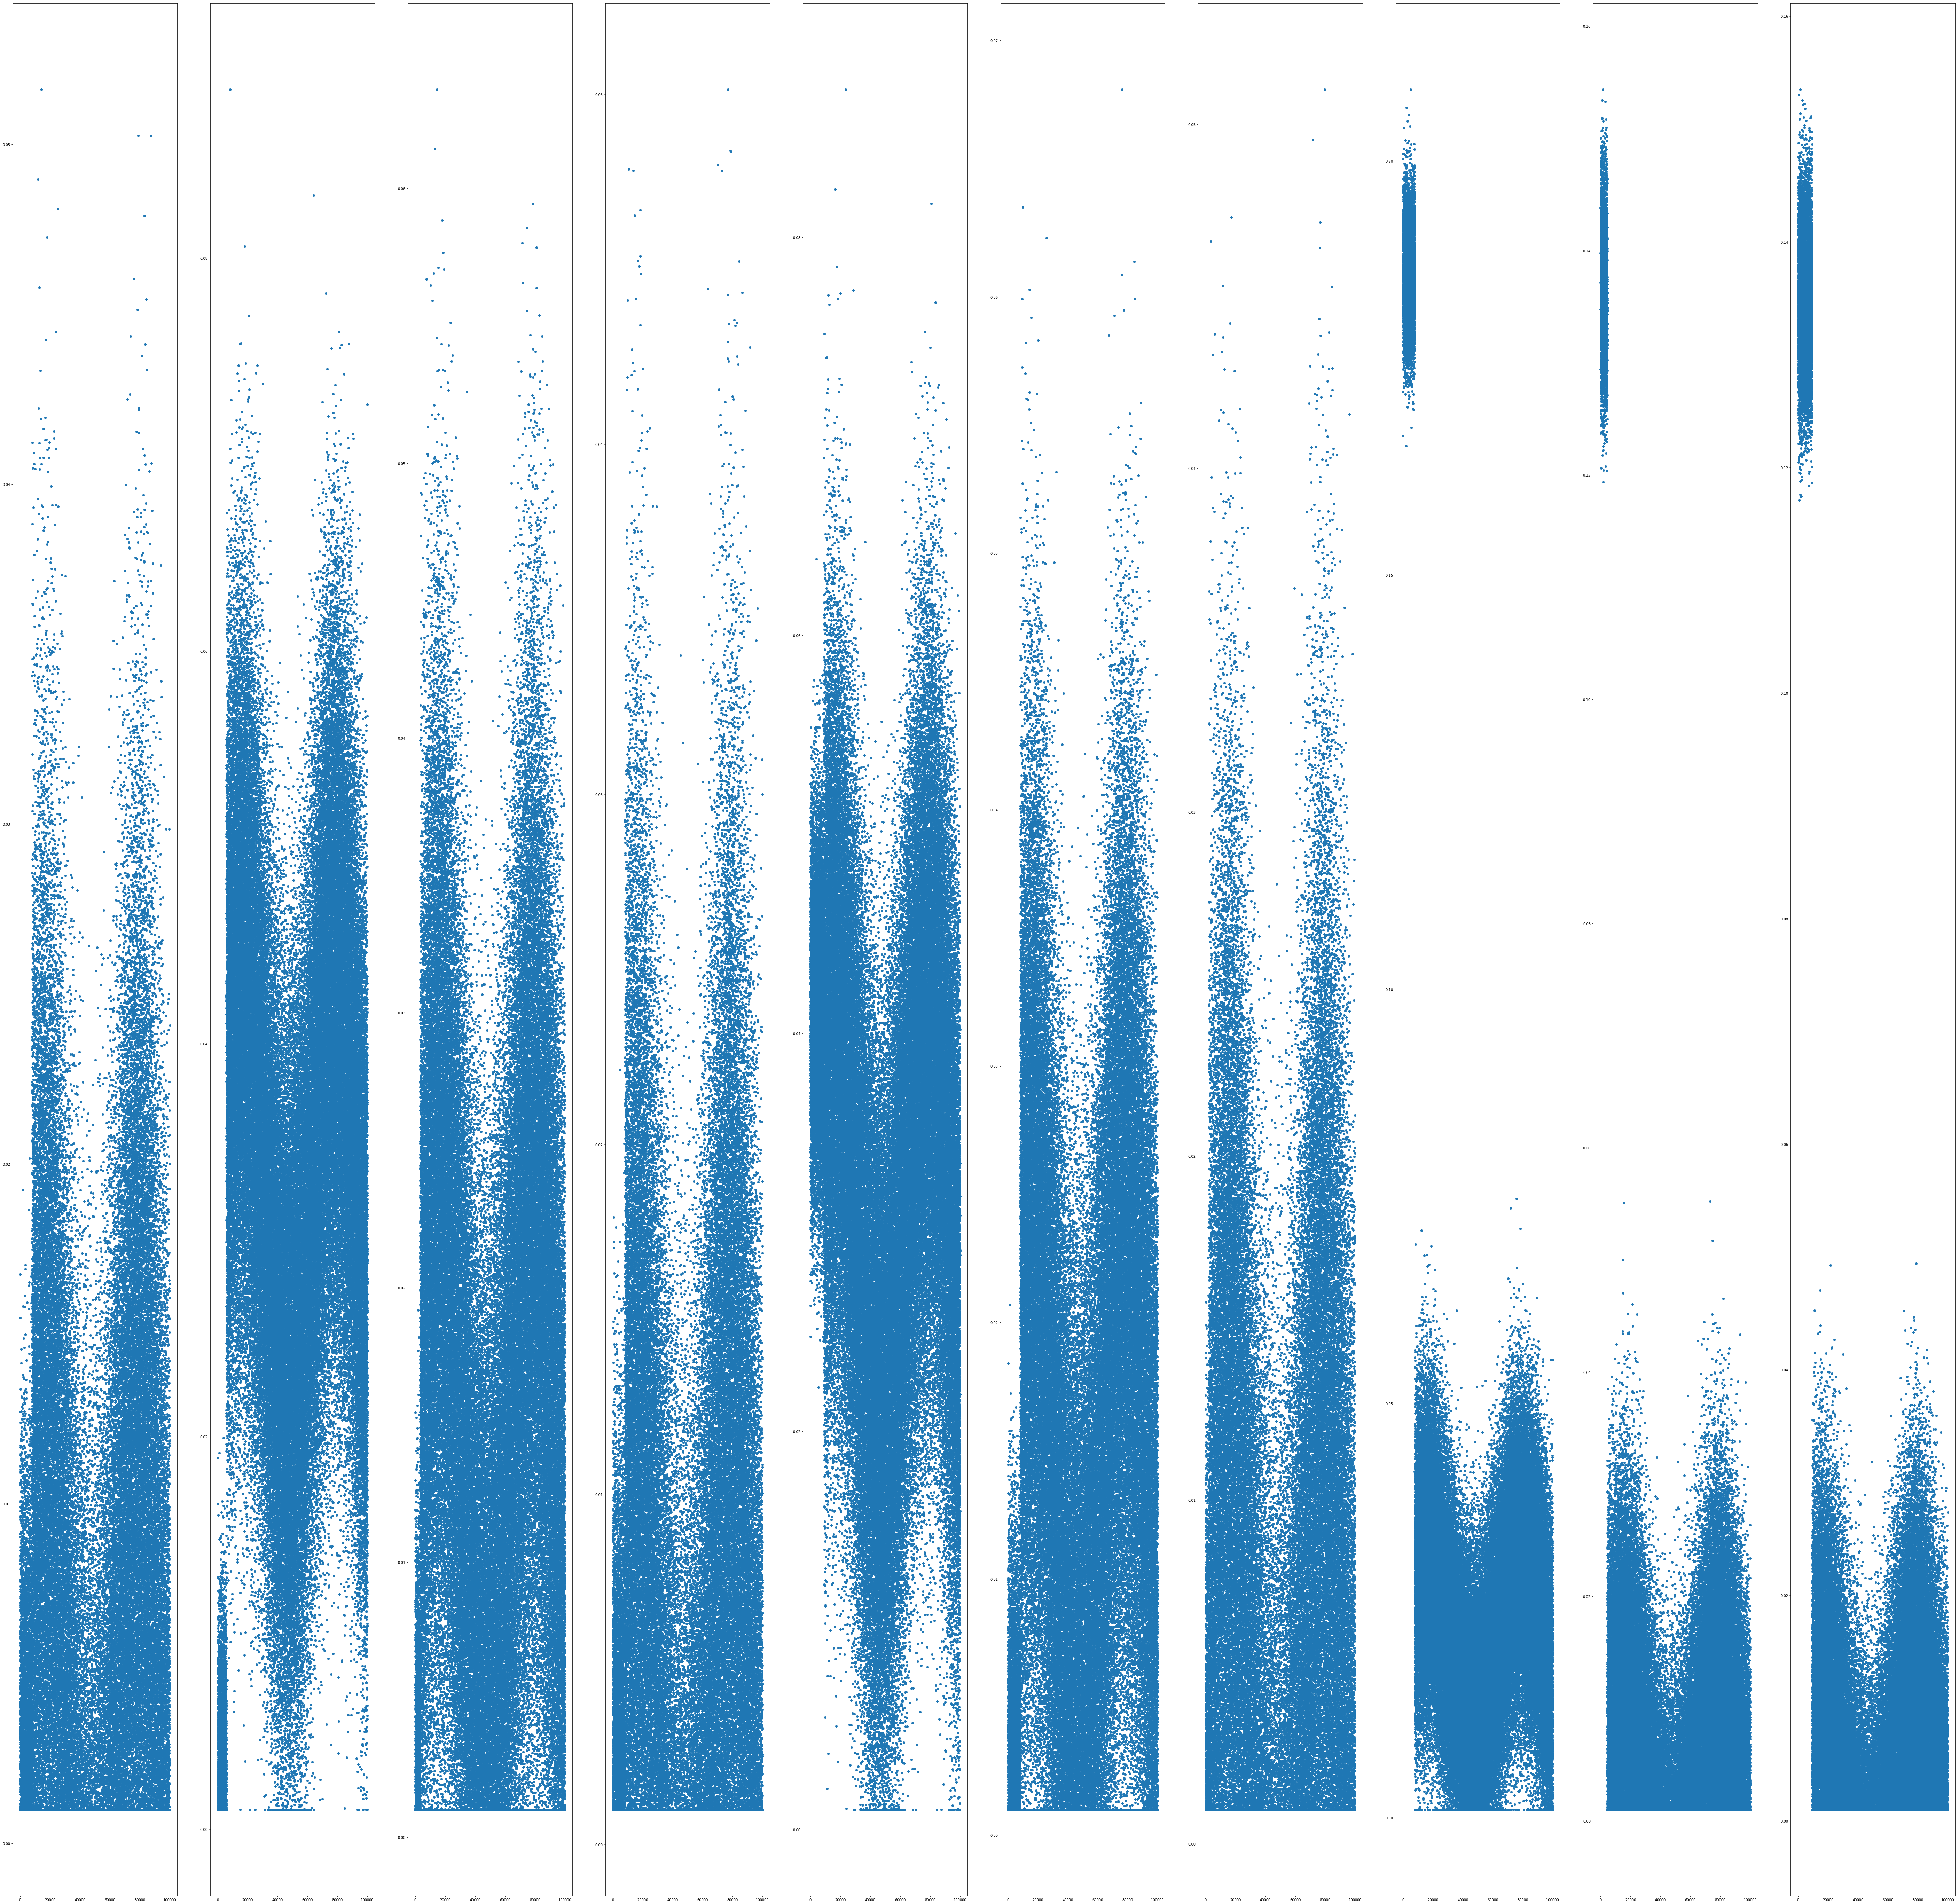

In [5]:
f = plt.figure(figsize=(100,100))
for idx in range(N_MODELS):
    #plt.subplot(5,2,idx+1)
    ax = f.add_subplot(1, 10, idx+1)
    ax.plot(np.arange(MAX_TRAFFIC), true_ctrs[idx], 'o')

#plt.show()

In [6]:
# A/B/n test framework evenly divides the entire traffic into multiple subsets
avg_gt_ctrs = [np.mean(true_ctrs[i]) for i in range(N_MODELS)]
true_rank = list(np.argsort(avg_gt_ctrs))
true_rank.reverse()
print ('true rank: ')
print (true_rank)

true rank: 
[7, 4, 1, 9, 2, 5, 8, 6, 3, 0]


In [7]:
avg_gt_ctrs

[0.006451439719276814,
 0.032696994462888145,
 0.015404550984742495,
 0.006452963568653562,
 0.033227151825995685,
 0.014932217952581255,
 0.006769696575588406,
 0.03608712287386985,
 0.012601498904313141,
 0.018745500458087348]

### Functions

In [8]:
def monte_carlo_simulation(models, draw=100):
    """
    Monte Carlo simulation of thetas. Each model's click through
    rate follows a beta distribution.
    
    Parameters
    ----------
    models list: list of model objects.
    draw int: number of draws in Monte Carlo simulation.
    
    Returns
    -------
    mc np.matrix: Monte Carlo matrix of dimension (draw, n_models).
    p_winner list[float]: probability of each model being the winner.
    """
    # Monte Carlo sampling
    alphas = [model.a for model in models]
    betas = [model.b for model in models]
    mc = np.matrix(np.random.beta(alphas, betas, size=[draw, len(models)]))
    
    # count frequency of each model being winner 
    counts = [0 for _ in models]
    winner_idxs = np.asarray(mc.argmax(axis=1)).reshape(draw,)
    for idx in winner_idxs:
        counts[idx] += 1
    
    # divide by draw to approximate probability distribution
    p_winner = [count / draw for count in counts]
    return mc, p_winner

In [9]:
def e_greedy(models, n, n_learning=int(MAX_TRAFFIC/20), epsilon=0.05):
    # random idx for n learning trials
    idx = np.random.choice(N_MODELS) if n < n_learning else np.argmax([model.mean() for model in models])
    # with 1 - epsilon probability take a random sample (explore) otherwise exploit
    idx = np.random.choice(N_MODELS) if np.random.uniform(0, 1) > epsilon else idx
    return idx

In [10]:
def thompson_sampling(models):
    """
    Stochastic sampling: take one draw for each models
    divert traffic to best draw.
    
    @param arms list[model]: list of model objects
    @return idx int: index of winning model from sample
    """
    sample_p = [model.draw_ctr() for model in models]
    idx = np.argmax(sample_p)
    return idx

In [11]:
def should_terminate(p_winner, est_ctrs, mc, alpha=0.05):
    """
    Decide whether experiument should terminate. When value remaining in
    experiment is less than 1% of the winning model's click through rate.
    
    Parameters
    ----------
    p_winner list[float]: probability of each model being the winner.
    est_ctrs list[float]: estimated click through rates.
    mc np.matrix: Monte Carlo matrix of dimension (draw, N_MODELS).
    alpha: controlling for type I error
    
    @returns bool: True if experiment should terminate.
    """
    winner_idx = np.argmax(p_winner)
    values_remaining = (mc.max(axis=1) - mc[:, winner_idx]) / mc[:, winner_idx]
    pctile = np.percentile(values_remaining, q=100 * (1 - alpha))
    return pctile < 0.01 * est_ctrs[winner_idx]

In [12]:
def plot_history(ctrs, est_ctrs, traffic_record, df_history, title, rolling=10, fname=None, transparent=False):
    """
    Plot evolution of conversion rates estimates or winner probability for each model.
    
    Parameters
    ----------
    ctr, est_ctrs list[float]: true ctrs and estiamted ctrs.
    traffic_record: traffic consumed for each model
    df_history list[list[float]]: a nested list of each model's history.
    rolling int: rolling window length.
    fname str: enter file name if need to store, including '.png'.
    transparent bool: make background transparent.
    """
    true_winner_idx = np.argmax(ctrs)
    winner_idx = np.argmax(est_ctrs)
    
    cols = ["model_%i_ctr=%.2f"%(i + 1, ctr) for i, ctr in enumerate(ctrs)]
    data = {col : hist for col, hist in zip(cols, df_history)}
    df_history_ma = pd.DataFrame(data).rolling(rolling).mean()
    
    plt.figure(figsize=(20, 5))
    for i, col in enumerate(cols):
        if i == true_winner_idx :
            plt.plot(df_history_ma[col], lw=2, color='b')
        elif i == winner_idx:
            plt.plot(df_history_ma[col], lw=2, color='r')
        else:
            plt.plot(df_history_ma[col], alpha=0.5)

    legend = ["%d: true ctr = %.3f, est ctr = %.3f, traffic = %d"%(idx, zipped[0], zipped[1], zipped[2]) for idx, zipped in enumerate(zip(ctrs, est_ctrs, traffic_record))]
    plt.legend(legend, frameon=False, loc='upper center', ncol=3)
    plt.title(title)
    plt.ylim(0, 1)
    
    plt.show()

### Evaluation framework
* A/B/n
* Multi-armed bandit with e-greedy
* Thompson sampling

In [13]:
def simulate(true_ctrs, alpha=0.01, burn_in=5000, draw=100, early_stop=True, option='abn'):
    """
    Simulate evaluation of recommenders with various frameworks
    
    Parameters
    ----------
    true_ctrs: true ctr of each model
    option: 'abn' or 'mab' or 'thompson'
    draw: number of draws in Monte Carlo simulation.
    """
    models = [Recommender(idx=i, gt_ctr=true_ctrs[i]) for i in range(N_MODELS)]
    history_p = [[] for _ in range(N_MODELS)]
    
    is_test = 1
    best_model = -1
    for n in range(MAX_TRAFFIC):
        mid = random.randint(0, N_USERS)
        
        if is_test:
            if option == 'abn':
                # select model based on the mid
                idx = mid % N_MODELS
            elif option == 'mab':
                idx = e_greedy(models, n)
            elif option == 'thompson':
                idx = thompson_sampling(models)
            else:
                print ('wrong option')
                exit(-1)
        else:
            assert (best_model != -1)
            idx = best_model
        model = models[idx]
        
        # click is determined based on the GT ctr of model
        if np.random.rand() < model.gt_ctr[n]:
            model.record_success()
        else:
            model.record_failure()
        
        # record current estimates of each model being winner
        if is_test:
            mc, p_winner = monte_carlo_simulation(models, draw)
            for j, p in enumerate(p_winner):
                history_p[j].append(p)

            # record current estimates of each model's performance
            est_ctrs = [model.mean() for model in models]

            # terminate when value remaining is negligible
            if early_stop and n >= burn_in and should_terminate(p_winner, est_ctrs, mc, alpha):
                best_model = np.argmax(p_winner)
                print("Test terminated at iteration %i, best model is %d"%(n, best_model))
                is_test = 0
        else:
            for j, p in enumerate(p_winner):
                history_p[j].append(p)
        
    traffic_record = [model.a + model.b - 2 for model in models]
    overall_ctr = np.sum([model.a - 1 for model in models]) / np.sum(traffic_record)

    return est_ctrs, traffic_record, history_p, overall_ctr

### Simulation of model evaluation

In [14]:
overall_ctr_list = []
wasted_traffics_list = []

#### A/B/n test without earlystop

In [15]:
est_ctrs, traffic_record, history_p, overall_ctr = simulate(true_ctrs, early_stop=False, option='abn')
est_rank = list(np.argsort(est_ctrs))
est_rank.reverse()
print ('estimated rank: ')
print (est_rank)

print ('overall ctr: %f' % (overall_ctr))
est_rank.remove(true_rank[0])
wasted_traffics_ratio = np.sum([traffic_record[idx] for idx in est_rank]) / np.sum(traffic_record)
print ('%f %% of wasted traffics' % (wasted_traffics_ratio))

overall_ctr_list.append(overall_ctr)
wasted_traffics_list.append(wasted_traffics_ratio)

estimated rank: 
[7, 1, 4, 9, 2, 5, 8, 3, 6, 0]
overall ctr: 0.018670
0.900550 % of wasted traffics


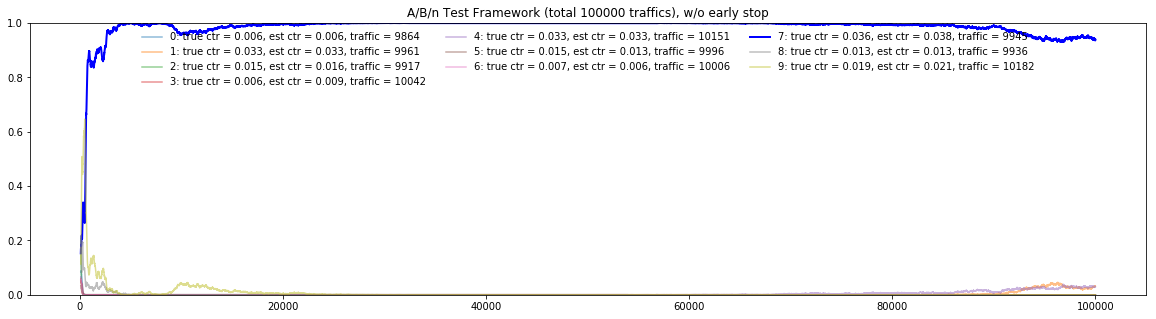

In [16]:
plot_history(avg_gt_ctrs, est_ctrs, traffic_record, history_p, title="A/B/n Test Framework (total %i traffics), w/o early stop"% sum(traffic_record), rolling=100)

#### A/B/n test with earlystop

In [17]:
est_ctrs, traffic_record, history_p, overall_ctr = simulate(true_ctrs, early_stop=True, option='abn')
est_rank = list(np.argsort(est_ctrs))
est_rank.reverse()
print ('estimated rank: ')
print (est_rank)

print ('overall ctr: %f' % (overall_ctr))
est_rank.remove(true_rank[0])
wasted_traffics_ratio = np.sum([traffic_record[idx] for idx in est_rank]) / np.sum(traffic_record)
print ('%f %% of wasted traffics' % (wasted_traffics_ratio))

overall_ctr_list.append(overall_ctr)
wasted_traffics_list.append(wasted_traffics_ratio)

Test terminated at iteration 5098, best model is 7
estimated rank: 
[7, 9, 8, 4, 2, 6, 0, 3, 1, 5]
overall ctr: 0.029240
0.045940 % of wasted traffics


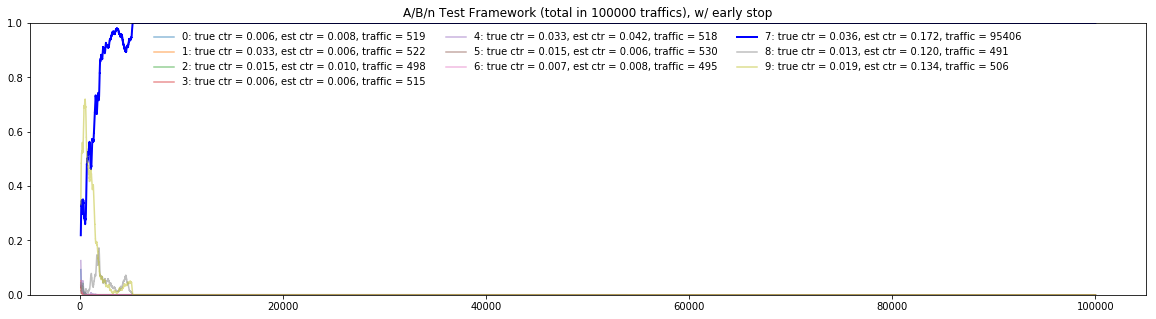

In [18]:
plot_history(avg_gt_ctrs, est_ctrs, traffic_record, history_p, title="A/B/n Test Framework (total in %i traffics), w/ early stop"% sum(traffic_record), rolling=100)

#### Multi-armed bandit without earlystop

In [19]:
est_ctrs, traffic_record, history_p, overall_ctr = simulate(true_ctrs, early_stop=False, option='mab')
est_rank = list(np.argsort(est_ctrs))
est_rank.reverse()
print ('estimated rank: ')
print (est_rank)

print ('overall ctr: %f' % (overall_ctr))
est_rank.remove(true_rank[0])
wasted_traffics_ratio = np.sum([traffic_record[idx] for idx in est_rank]) / np.sum(traffic_record)
print ('%f %% of wasted traffics' % (wasted_traffics_ratio))

overall_ctr_list.append(overall_ctr)
wasted_traffics_list.append(wasted_traffics_ratio)

estimated rank: 
[1, 7, 4, 9, 5, 2, 8, 0, 3, 6]
overall ctr: 0.018870
0.862470 % of wasted traffics


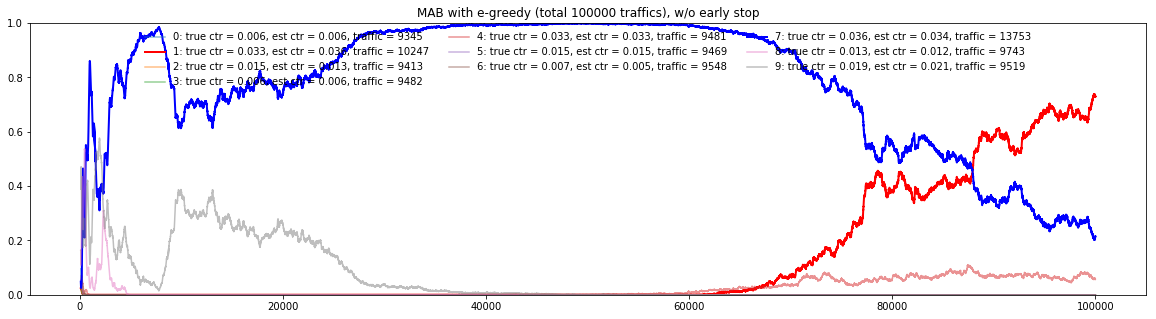

In [20]:
plot_history(avg_gt_ctrs, est_ctrs, traffic_record, history_p, title="MAB with e-greedy (total %i traffics), w/o early stop"% sum(traffic_record), rolling=100)

#### Multi-armed bandit with earlystop

In [21]:
est_ctrs, traffic_record, history_p, overall_ctr = simulate(true_ctrs, option='mab')
est_rank = list(np.argsort(est_ctrs))
est_rank.reverse()
print ('estimated rank: ')
print (est_rank)

print ('overall ctr: %f' % (overall_ctr))
est_rank.remove(true_rank[0])
wasted_traffics_ratio = np.sum([traffic_record[idx] for idx in est_rank]) / np.sum(traffic_record)
print ('%f %% of wasted traffics' % (wasted_traffics_ratio))

overall_ctr_list.append(overall_ctr)
wasted_traffics_list.append(wasted_traffics_ratio)

Test terminated at iteration 5013, best model is 7
estimated rank: 
[7, 8, 9, 4, 2, 6, 3, 0, 5, 1]
overall ctr: 0.029450
0.045060 % of wasted traffics


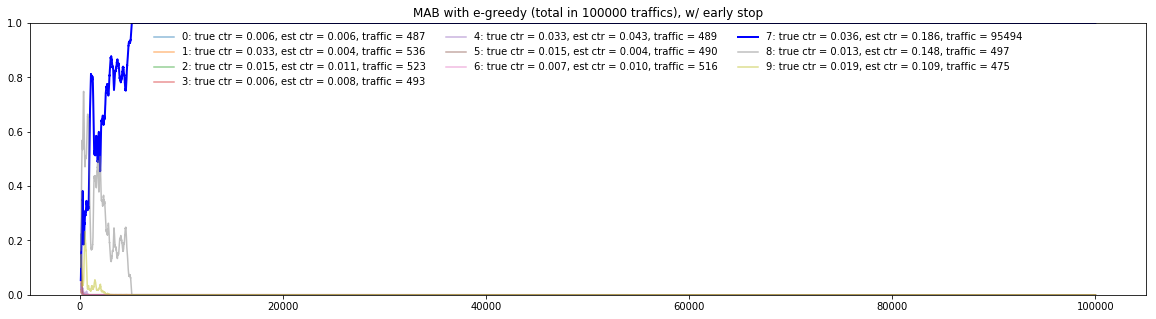

In [22]:
plot_history(avg_gt_ctrs, est_ctrs, traffic_record, history_p, title="MAB with e-greedy (total in %i traffics), w/ early stop"% sum(traffic_record), rolling=100)

#### Thompson without earlystopping

In [23]:
est_ctrs, traffic_record, history_p, overall_ctr = simulate(true_ctrs, early_stop=False, option='thompson')
est_rank = list(np.argsort(est_ctrs))
est_rank.reverse()
print ('estimated rank: ')
print (est_rank)

print ('overall ctr: %f' % (overall_ctr))
est_rank.remove(true_rank[0])
wasted_traffics_ratio = np.sum([traffic_record[idx] for idx in est_rank]) / np.sum(traffic_record)
print ('%f %% of wasted traffics' % (wasted_traffics_ratio))

overall_ctr_list.append(overall_ctr)
wasted_traffics_list.append(wasted_traffics_ratio)

estimated rank: 
[7, 4, 1, 9, 8, 5, 6, 2, 3, 0]
overall ctr: 0.037710
0.153380 % of wasted traffics


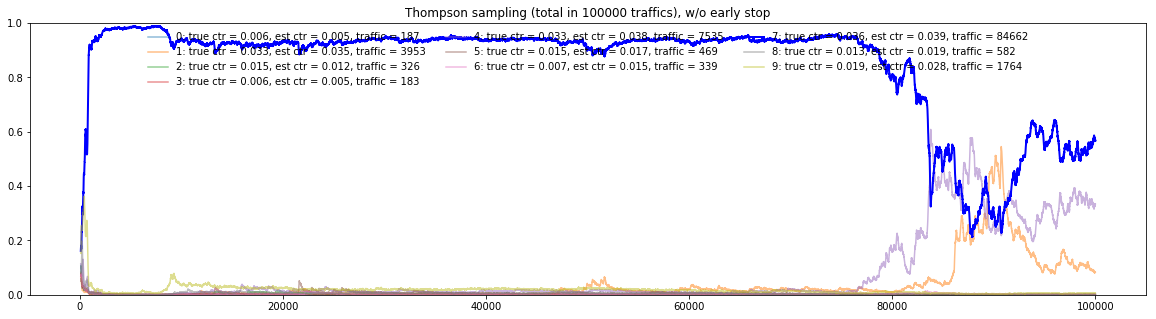

In [24]:
plot_history(avg_gt_ctrs, est_ctrs, traffic_record, history_p, title="Thompson sampling (total in %i traffics), w/o early stop"% sum(traffic_record), rolling=100)

#### Thompson with earlystopping

In [25]:
est_ctrs, traffic_record, history_p, overall_ctr = simulate(true_ctrs, option='thompson')
est_rank = list(np.argsort(est_ctrs))
est_rank.reverse()
print ('estimated rank: ')
print (est_rank)

print ('overall ctr: %f' % (overall_ctr))
est_rank.remove(true_rank[0])
wasted_traffics_ratio = np.sum([traffic_record[idx] for idx in est_rank]) / np.sum(traffic_record)
print ('%f %% of wasted traffics' % (wasted_traffics_ratio))

overall_ctr_list.append(overall_ctr)
wasted_traffics_list.append(wasted_traffics_ratio)

Test terminated at iteration 5001, best model is 7
estimated rank: 
[7, 9, 6, 8, 4, 5, 3, 1, 0, 2]
overall ctr: 0.036100
0.006170 % of wasted traffics


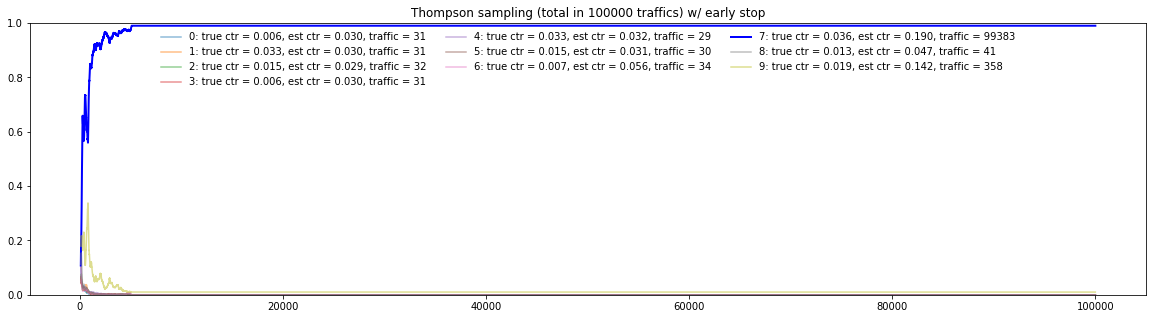

In [26]:
plot_history(avg_gt_ctrs, est_ctrs, traffic_record, history_p, title="Thompson sampling (total in %i traffics) w/ early stop"% sum(traffic_record), rolling=100)

### Summary

In [27]:
print ('--Summary--')
frameworks = ['A/B/n test', 'MAB with e-greedy', 'Thompson sampling']

for i in range(len(overall_ctr_list)):
    framework = frameworks[int(i/2)]
    if i % 2:
        s = 'w/'
    else:
        s = 'w/o'
        
    print ('%s, %s early stop - overall CTR: %f, wasted traffic: %f' % (framework, s, overall_ctr_list[i], wasted_traffics_list[i]))

--Summary--
A/B/n test, w/o early stop - overall CTR: 0.018670, wasted traffic: 0.900550
A/B/n test, w/ early stop - overall CTR: 0.029240, wasted traffic: 0.045940
MAB with e-greedy, w/o early stop - overall CTR: 0.018870, wasted traffic: 0.862470
MAB with e-greedy, w/ early stop - overall CTR: 0.029450, wasted traffic: 0.045060
Thompson sampling, w/o early stop - overall CTR: 0.037710, wasted traffic: 0.153380
Thompson sampling, w/ early stop - overall CTR: 0.036100, wasted traffic: 0.006170
